In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


In [6]:
print("=== Credit Card Fraud Detection - Exploratory Data Analysis ===\n")

# Load the preprocessed data
print("Loading preprocessed data...")
df = pd.read_csv('data/processed/cc_cleaned.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

=== Credit Card Fraud Detection - Exploratory Data Analysis ===

Loading preprocessed data...
Dataset shape: (281918, 34)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Hour', 'Day', 'Amount_Bins', 'Class']


In [7]:
# 1. Data Structure & Basic Info
print("\n" + "="*50)
print("1. DATA STRUCTURE & BASIC INFORMATION")
print("="*50)

print("\nBasic dataset info:")
print(f"Total transactions: {len(df):,}")
print(f"Number of features: {len(df.columns)}")
print(f"Data types:\n{df.dtypes.value_counts()}")

# Check for missing values
missing_values = df.isnull().sum()
print(f"\nMissing values: {missing_values.sum()}")
if missing_values.sum() > 0:
    print("Columns with missing values:")
    print(missing_values[missing_values > 0])


1. DATA STRUCTURE & BASIC INFORMATION

Basic dataset info:
Total transactions: 281,918
Number of features: 34
Data types:
float64    32
object      1
int64       1
Name: count, dtype: int64

Missing values: 0



Outlier detection (IQR method on scaled features):
Time outliers: 0 (0.00%)
Amount outliers: 31535 (11.19%)


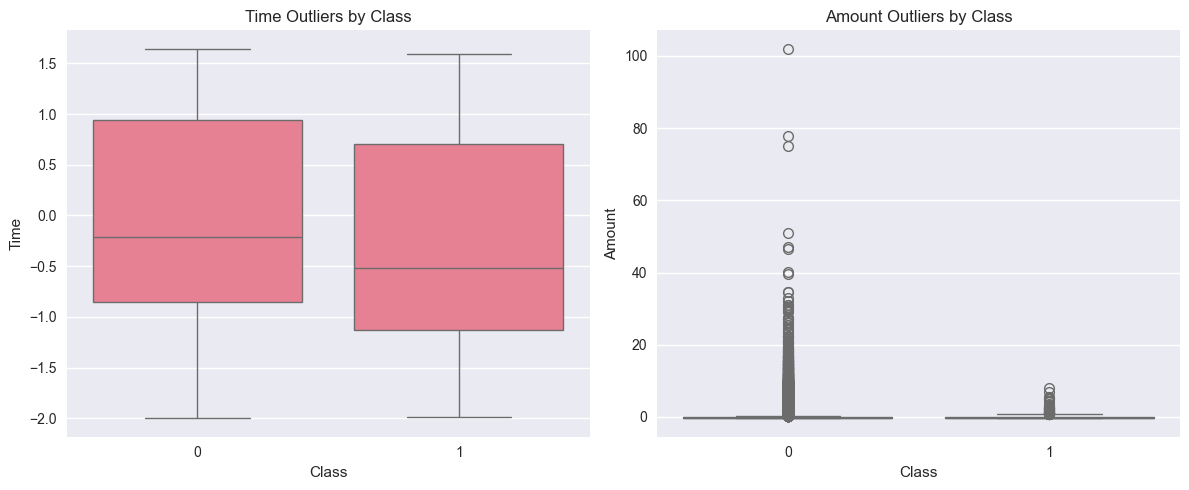

In [8]:
# Outliers in Amount and Time (pre-scaled for intuition; use scaled for analysis)
# Detect outliers using IQR
def detect_outliers(series, feature_name):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    print(f"{feature_name} outliers: {len(outliers)} ({len(outliers)/len(series)*100:.2f}%)")
    return lower_bound, upper_bound

# Since data is scaled, outliers are relative to standardized scale
print("\nOutlier detection (IQR method on scaled features):")
time_bounds = detect_outliers(df['Time'], 'Time')
amount_bounds = detect_outliers(df['Amount'], 'Amount')

# Boxplot for visual outliers
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df, x='Class', y='Time', ax=axes[0])
axes[0].set_title('Time Outliers by Class')
sns.boxplot(data=df, x='Class', y='Amount', ax=axes[1])
axes[1].set_title('Amount Outliers by Class')
plt.tight_layout()
plt.show()



2. CLASS IMBALANCE ANALYSIS

Class Distribution:
Legitimate (0): 281,470 transactions (99.841%)
Fraud (1): 448 transactions (0.159%)


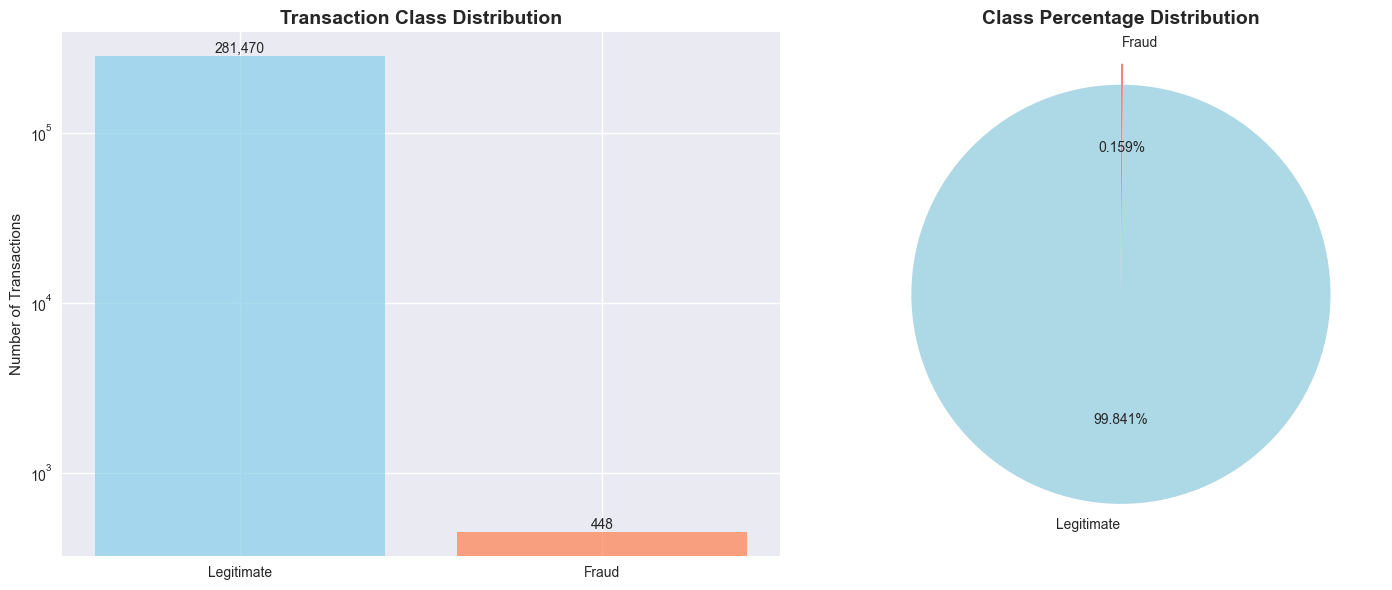

In [10]:
# 2. Class Imbalance Analysis
print("\n" + "="*50)
print("2. CLASS IMBALANCE ANALYSIS")
print("="*50)

class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

print(f"\nClass Distribution:")
print(f"Legitimate (0): {class_counts[0]:,} transactions ({class_percentages[0]:.3f}%)")
print(f"Fraud (1): {class_counts[1]:,} transactions ({class_percentages[1]:.3f}%)")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
bars = ax1.bar(['Legitimate', 'Fraud'], class_counts, color=['skyblue', 'coral'], alpha=0.7)
ax1.set_title('Transaction Class Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Transactions')
ax1.set_yscale('log')  # Log scale to see both classes clearly

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}', ha='center', va='bottom')
# Pie chart
colors = ['lightblue', 'lightcoral']
explode = (0, 0.1)  # explode the fraud slice
ax2.pie(class_counts, labels=['Legitimate', 'Fraud'], autopct='%1.3f%%',
        colors=colors, explode=explode, startangle=90)
ax2.set_title('Class Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


3. AMOUNT DISTRIBUTION ANALYSIS

Amount statistics by class:
          count      mean       std      min       25%       50%       75%  \
Class                                                                        
0      281470.0 -0.000265  0.999887 -0.35456 -0.330745 -0.264915 -0.043937   
1         448.0  0.166246  1.058100 -0.35456 -0.350618 -0.286002  0.090870   

              max  
Class              
0      101.959830  
1        8.111626  


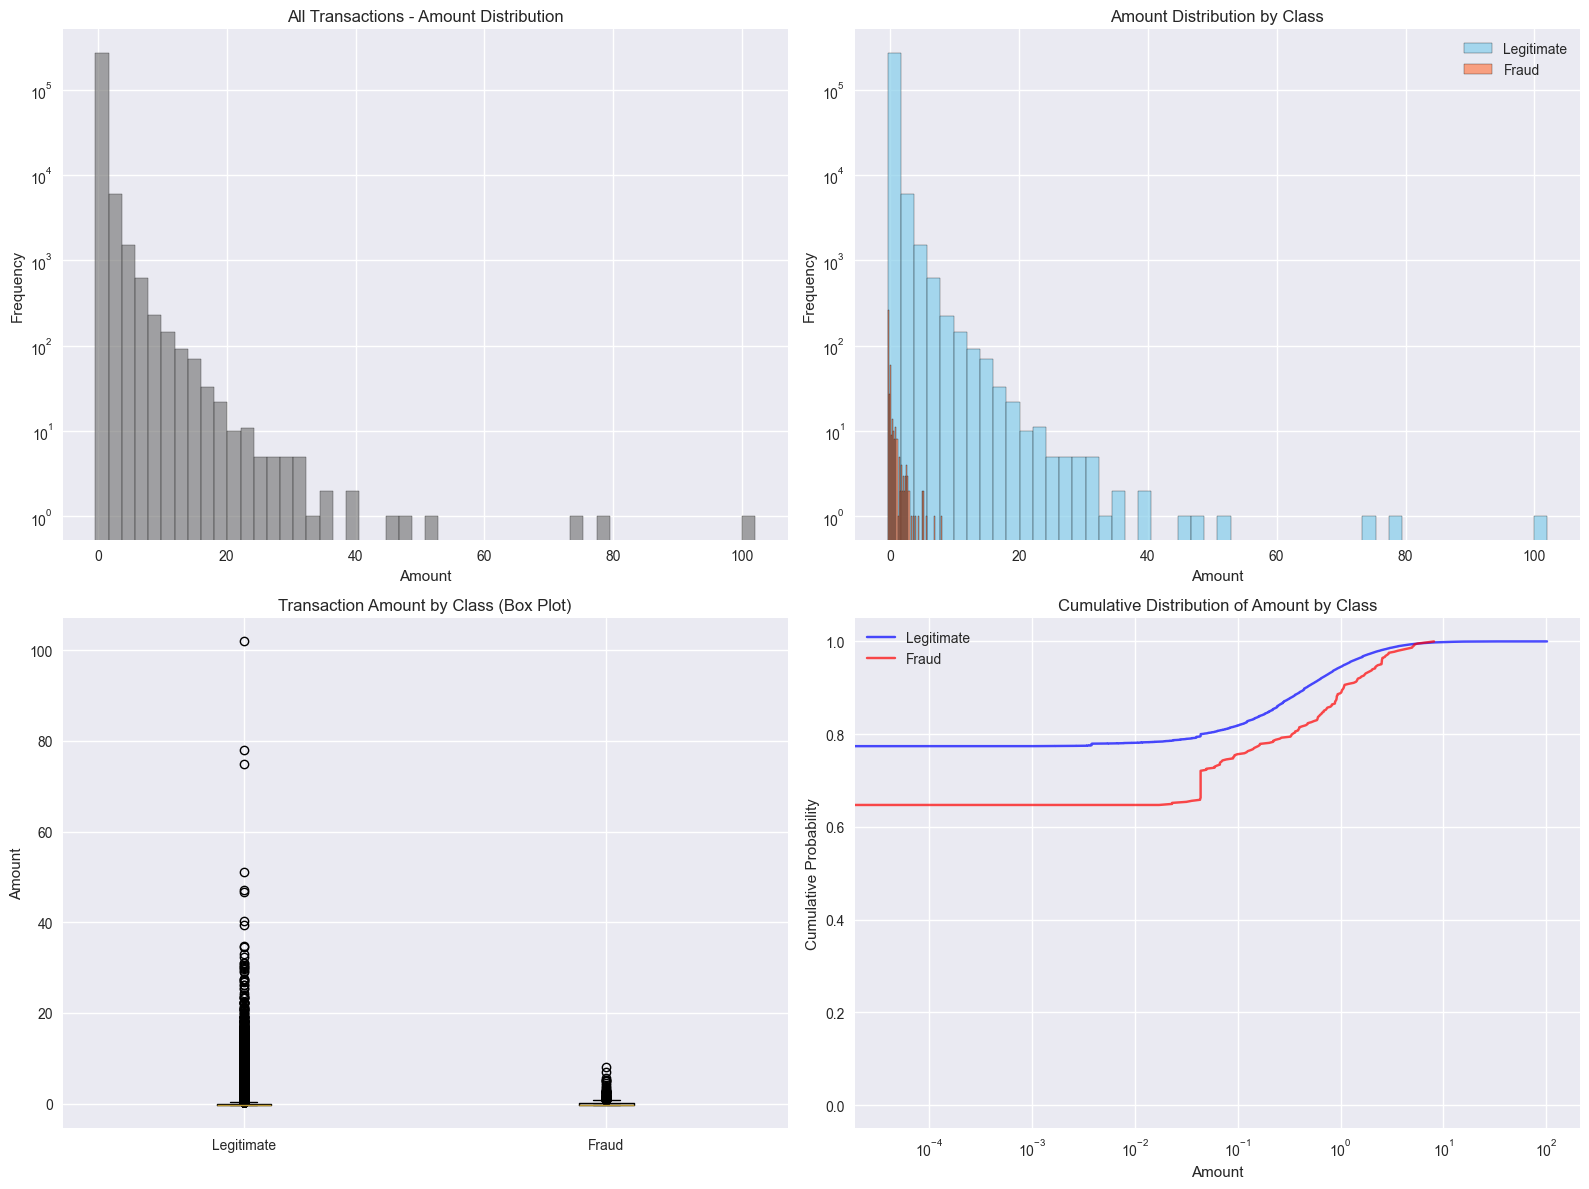

In [12]:
# 3. Amount Distribution Analysis
print("\n" + "="*50)
print("3. AMOUNT DISTRIBUTION ANALYSIS")
print("="*50)

# Statistical summary by class
print("\nAmount statistics by class:")
amount_stats = df.groupby('Class')['Amount'].describe()
print(amount_stats)

# Visualize amount distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram - All transactions
axes[0,0].hist(df['Amount'], bins=50, alpha=0.7, color='gray', edgecolor='black')
axes[0,0].set_title('All Transactions - Amount Distribution')
axes[0,0].set_xlabel('Amount')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_yscale('log')

# Histogram - By class
axes[0,1].hist(df[df['Class'] == 0]['Amount'], bins=50, alpha=0.7, 
               color='skyblue', edgecolor='black', label='Legitimate')
axes[0,1].hist(df[df['Class'] == 1]['Amount'], bins=50, alpha=0.7, 
               color='coral', edgecolor='black', label='Fraud')
axes[0,1].set_title('Amount Distribution by Class')
axes[0,1].set_xlabel('Amount')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].set_yscale('log')

# Box plot - By class
legit_amounts = df[df['Class'] == 0]['Amount']
fraud_amounts = df[df['Class'] == 1]['Amount']

axes[1,0].boxplot([legit_amounts, fraud_amounts], labels=['Legitimate', 'Fraud'])
axes[1,0].set_title('Transaction Amount by Class (Box Plot)')
axes[1,0].set_ylabel('Amount')

# Cumulative distribution
for class_val, color, label in [(0, 'blue', 'Legitimate'), (1, 'red', 'Fraud')]:
    amounts_sorted = np.sort(df[df['Class'] == class_val]['Amount'])
    y_vals = np.arange(1, len(amounts_sorted) + 1) / len(amounts_sorted)
    axes[1,1].plot(amounts_sorted, y_vals, color=color, label=label, alpha=0.7)

axes[1,1].set_title('Cumulative Distribution of Amount by Class')
axes[1,1].set_xlabel('Amount')
axes[1,1].set_ylabel('Cumulative Probability')
axes[1,1].legend()
axes[1,1].set_xscale('log')

plt.tight_layout()
plt.show()


4. TIME ANALYSIS


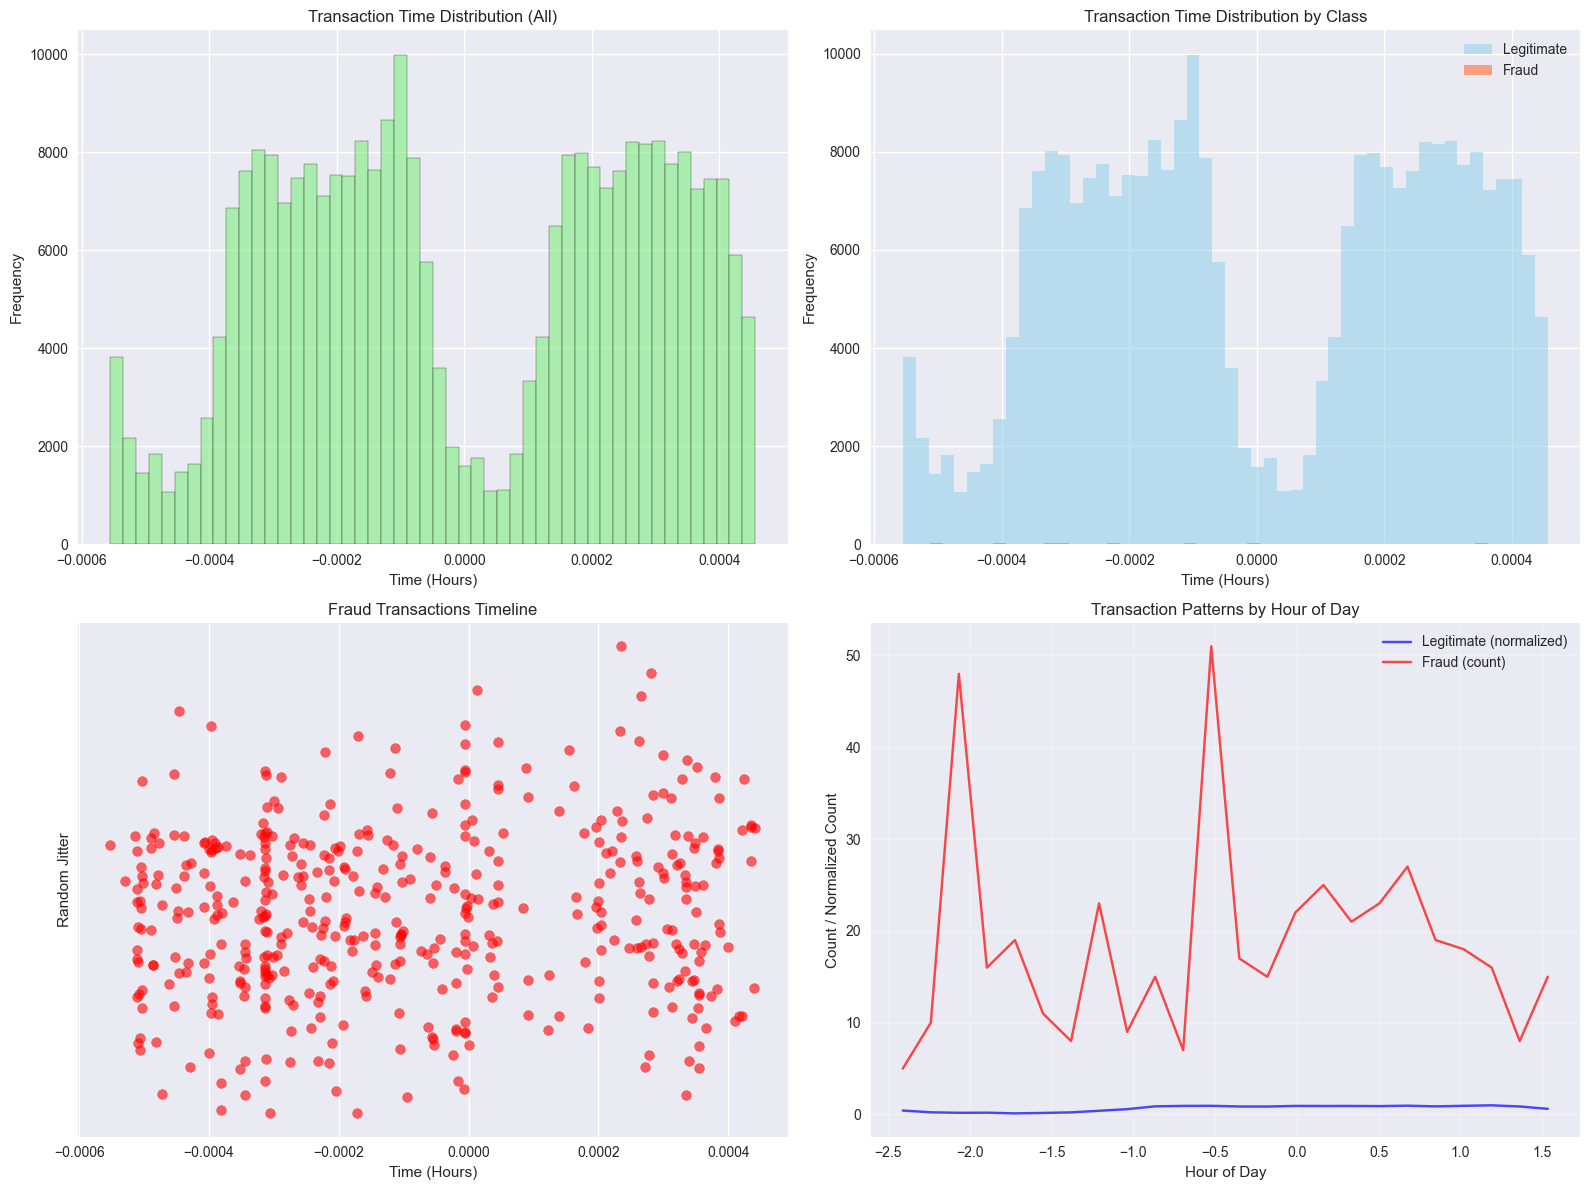

In [14]:
# 4. Time Analysis
print("\n" + "="*50)
print("4. TIME ANALYSIS")
print("="*50)

# Convert time to hours for better interpretation
df['Time_Hours'] = df['Time'] / 3600  # Convert to hours

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Time distribution - all transactions
axes[0,0].hist(df['Time_Hours'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,0].set_title('Transaction Time Distribution (All)')
axes[0,0].set_xlabel('Time (Hours)')
axes[0,0].set_ylabel('Frequency')

# Time distribution by class
axes[0,1].hist(df[df['Class'] == 0]['Time_Hours'], bins=50, alpha=0.5, 
               color='skyblue', label='Legitimate')
axes[0,1].hist(df[df['Class'] == 1]['Time_Hours'], bins=50, alpha=0.7, 
               color='coral', label='Fraud')
axes[0,1].set_title('Transaction Time Distribution by Class')
axes[0,1].set_xlabel('Time (Hours)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Fraud transactions over time
fraud_times = df[df['Class'] == 1]['Time_Hours']
axes[1,0].scatter(fraud_times, np.random.randn(len(fraud_times)) * 0.1, 
                  alpha=0.6, color='red', s=50)
axes[1,0].set_title('Fraud Transactions Timeline')
axes[1,0].set_xlabel('Time (Hours)')
axes[1,0].set_ylabel('Random Jitter')
axes[1,0].set_yticks([])

# Hourly pattern (if Hour feature exists)
if 'Hour' in df.columns:
    hourly_fraud = df[df['Class'] == 1].groupby('Hour').size()
    hourly_legit = df[df['Class'] == 0].groupby('Hour').size()
    
    axes[1,1].plot(hourly_legit.index, hourly_legit.values / hourly_legit.values.max(), 
                   'b-', alpha=0.7, label='Legitimate (normalized)')
    axes[1,1].plot(hourly_fraud.index, hourly_fraud.values, 'r-', 
                   alpha=0.7, label='Fraud (count)')
    axes[1,1].set_title('Transaction Patterns by Hour of Day')
    axes[1,1].set_xlabel('Hour of Day')
    axes[1,1].set_ylabel('Count / Normalized Count')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


5. PCA FEATURES ANALYSIS (V1-V28)

Top 10 PCA features with largest mean difference between classes:
 1. V17: Diff = 7.8424 (Legit: 0.0125, Fraud: -7.8300)
 2. V14: Diff = 7.1722 (Legit: 0.0114, Fraud: -7.1608)
 3. V12: Diff = 6.1715 (Legit: 0.0098, Fraud: -6.1617)
 4. V10: Diff = 5.0932 (Legit: 0.0081, Fraud: -5.0852)
 5. V16: Diff = 4.6908 (Legit: 0.0075, Fraud: -4.6834)
 6. V3: Diff = 4.5113 (Legit: 0.0072, Fraud: -4.5042)
 7. V7: Diff = 4.2627 (Legit: 0.0068, Fraud: -4.2560)
 8. V11: Diff = 3.6487 (Legit: -0.0058, Fraud: 3.6429)
 9. V4: Diff = 3.1643 (Legit: -0.0050, Fraud: 3.1593)
10. V18: Diff = 2.6562 (Legit: 0.0042, Fraud: -2.6520)


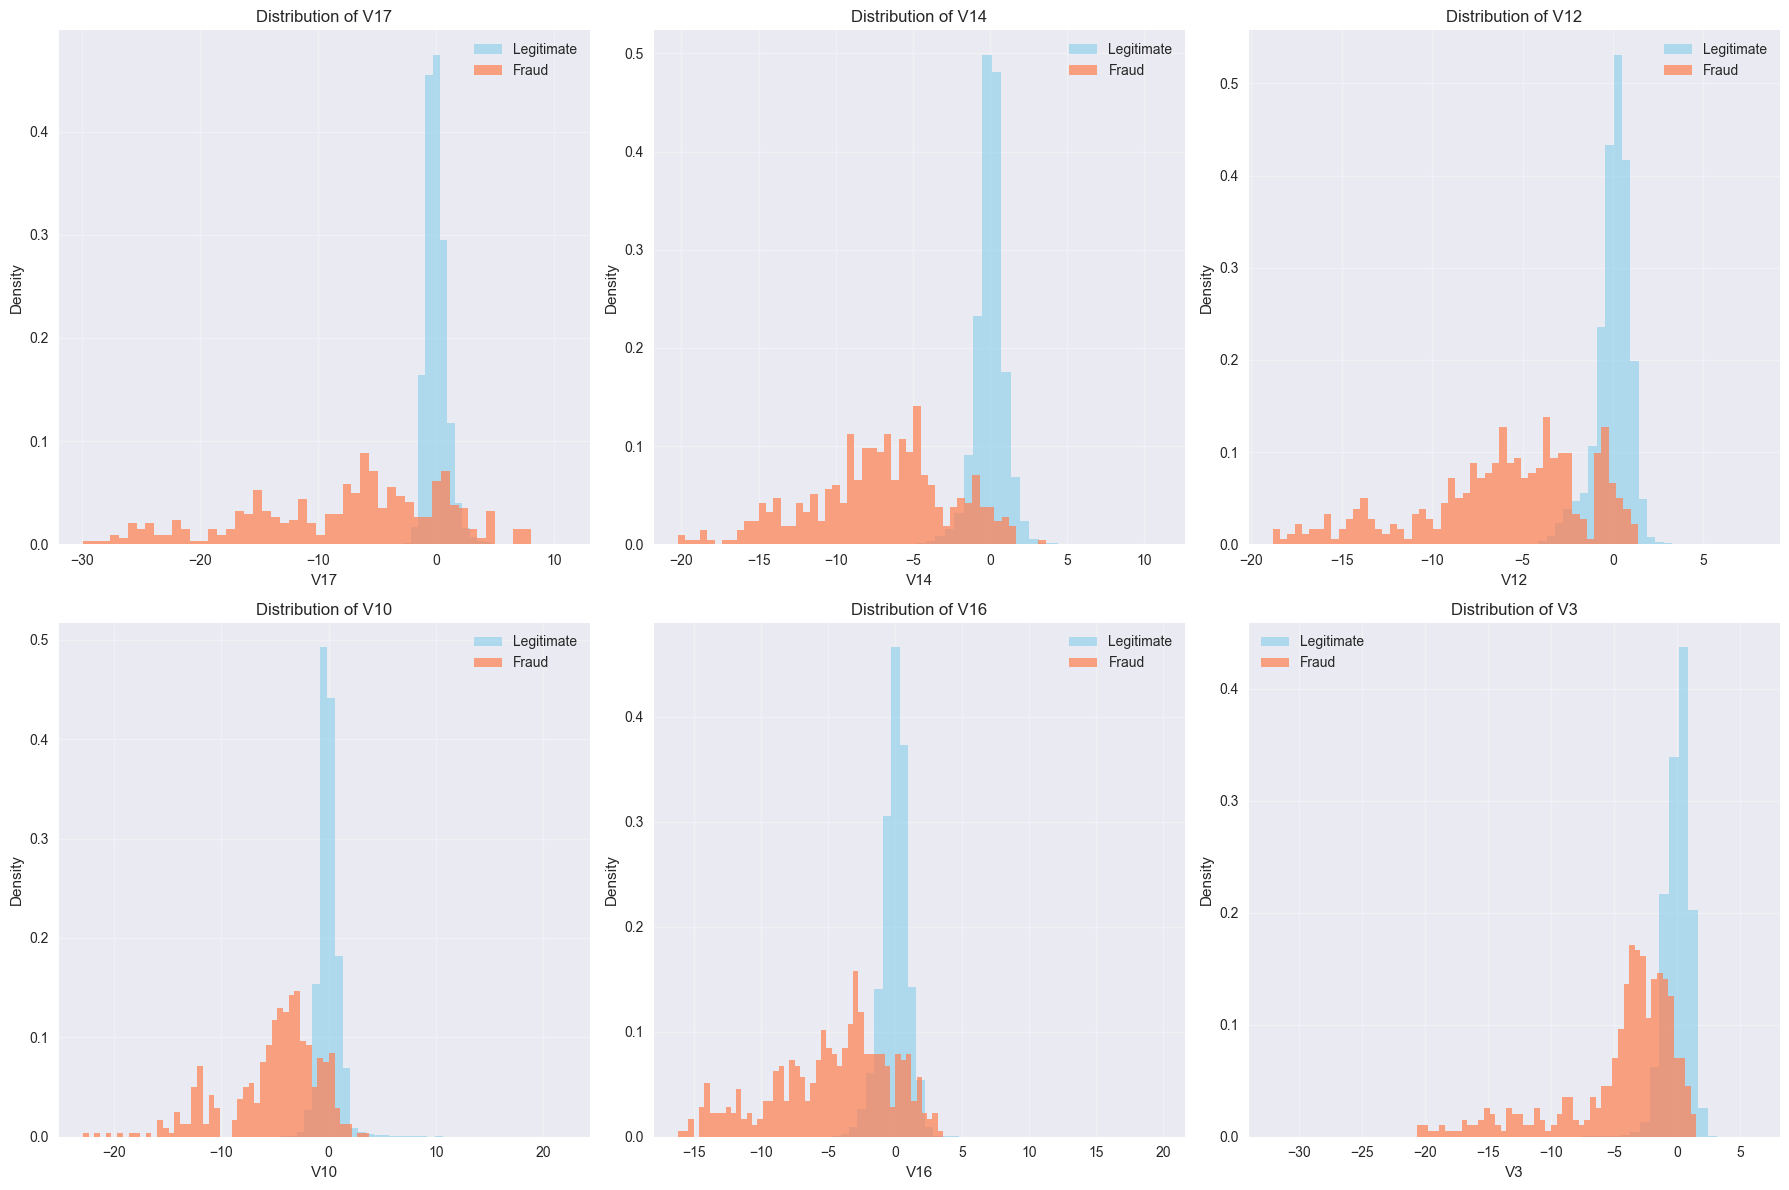

In [16]:
# 5. PCA Features Analysis (V1-V28)
print("\n" + "="*50)
print("5. PCA FEATURES ANALYSIS (V1-V28)")
print("="*50)

v_features = [f'V{i}' for i in range(1, 29)]

# Check which V features show the biggest difference between classes
print("\nTop 10 PCA features with largest mean difference between classes:")
feature_differences = []
for feature in v_features:
    legit_mean = df[df['Class'] == 0][feature].mean()
    fraud_mean = df[df['Class'] == 1][feature].mean()
    mean_diff = abs(fraud_mean - legit_mean)
    feature_differences.append((feature, mean_diff, legit_mean, fraud_mean))

# Sort by difference and display top 10
feature_differences.sort(key=lambda x: x[1], reverse=True)
for i, (feature, diff, legit_mean, fraud_mean) in enumerate(feature_differences[:10]):
    print(f"{i+1:2d}. {feature}: Diff = {diff:.4f} (Legit: {legit_mean:.4f}, Fraud: {fraud_mean:.4f})")

# Plot distributions for top 6 differentiating features
top_features = [fd[0] for fd in feature_differences[:6]]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
for i, feature in enumerate(top_features):
    # Legitimate transactions
    axes[i].hist(df[df['Class'] == 0][feature], bins=50, alpha=0.6, 
                 color='skyblue', label='Legitimate', density=True)
    # Fraud transactions
    axes[i].hist(df[df['Class'] == 1][feature], bins=50, alpha=0.7, 
                 color='coral', label='Fraud', density=True)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


6. CORRELATION ANALYSIS
Using 34 numerical features for correlation analysis

Top 10 features most positively correlated with Fraud:
Class    1.000000
V11      0.145334
V4       0.126041
V2       0.082979
V19      0.035825
V8       0.034943
V21      0.028161
V27      0.021790
V20      0.020028
V28      0.009177
Name: Class, dtype: float64

Top 10 features most negatively correlated with Fraud:
V9    -0.090130
V1    -0.094012
V18   -0.105803
V7    -0.169793
V3    -0.179695
V16   -0.186845
V10   -0.202874
V12   -0.245823
V14   -0.285683
V17   -0.312380
Name: Class, dtype: float64


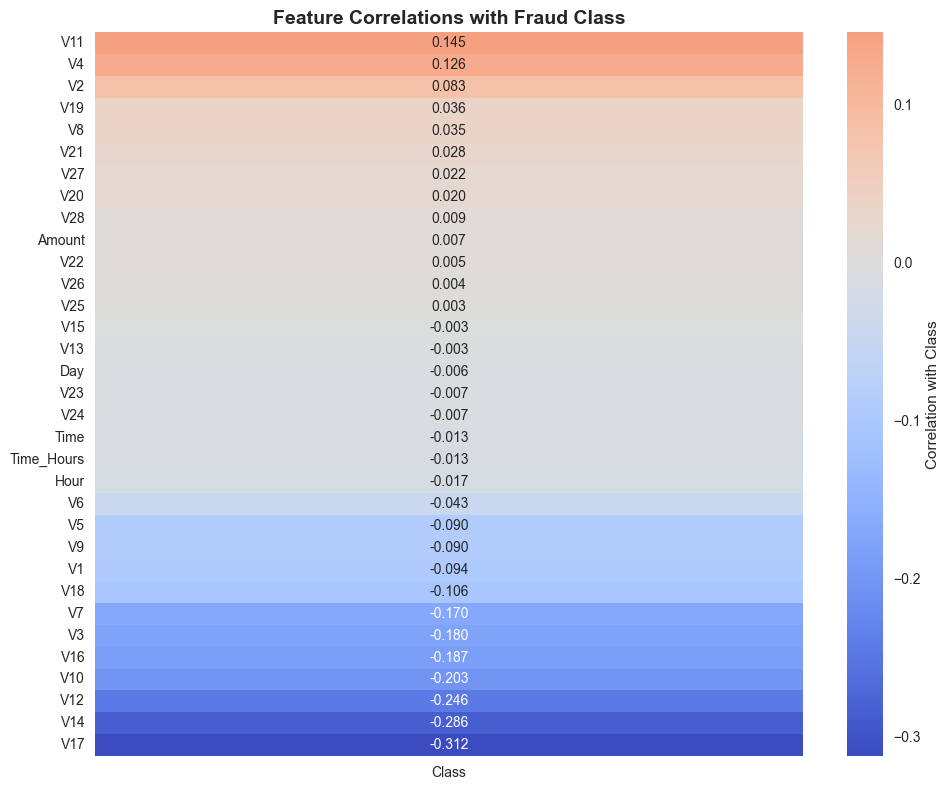

In [19]:
# 6. Correlation Analysis
print("\n" + "="*50)
print("6. CORRELATION ANALYSIS")
print("="*50)

# Select only numerical columns for correlation analysis
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Using {len(numerical_columns)} numerical features for correlation analysis")

# Calculate correlation with Class (only for numerical columns)
correlation_with_class = df[numerical_columns].corr()['Class'].sort_values(ascending=False)

print("\nTop 10 features most positively correlated with Fraud:")
print(correlation_with_class.head(10))

print("\nTop 10 features most negatively correlated with Fraud:")
print(correlation_with_class.tail(10))

# Plot correlation heatmap with Class (excluding Class itself for the heatmap)
plt.figure(figsize=(10, 8))
class_correlations = correlation_with_class.drop('Class', errors='ignore')  # Safely drop Class if present
sns.heatmap(class_correlations.to_frame(), annot=True, cmap='coolwarm', 
            center=0, fmt='.3f', cbar_kws={'label': 'Correlation with Class'})
plt.title('Feature Correlations with Fraud Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


7. FRAUD CLUSTERS VISUALIZATION


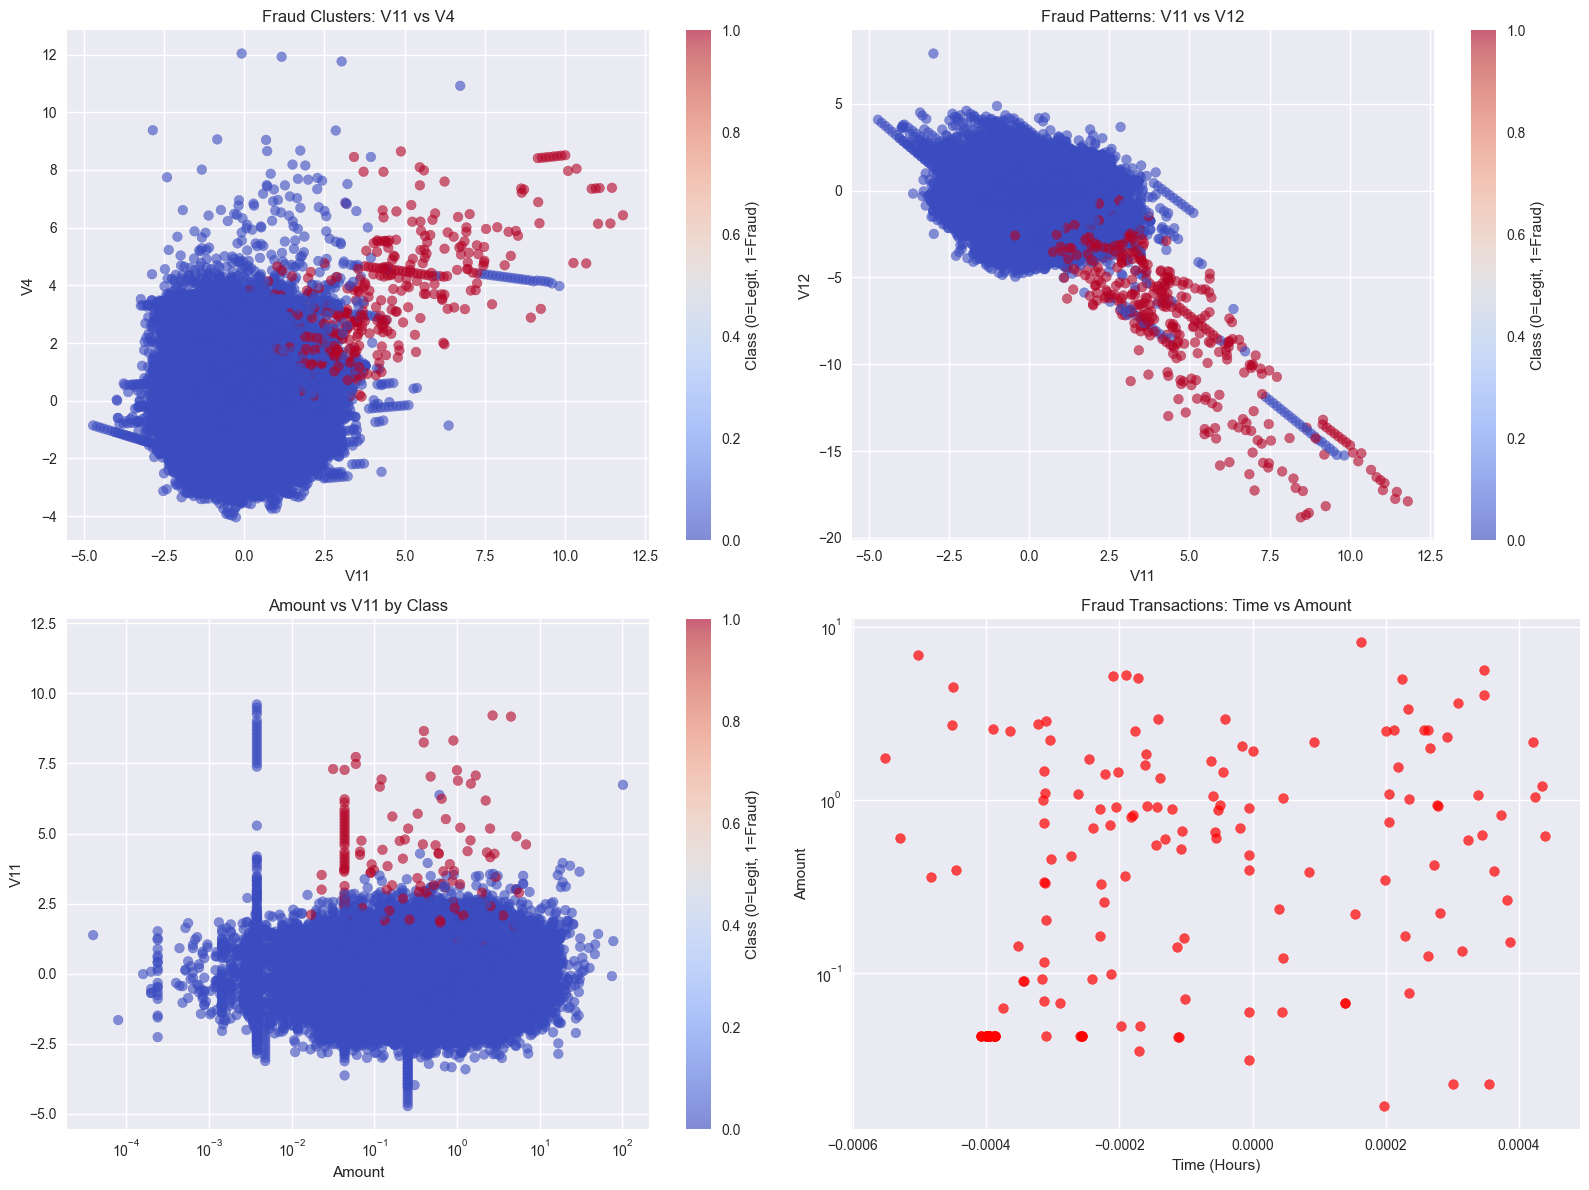

In [20]:
# 7. Fraud Clusters Visualization
print("\n" + "="*50)
print("7. FRAUD CLUSTERS VISUALIZATION")
print("="*50)

# Scatter plots using top correlated features
top_pos_corr = correlation_with_class.index[1:4]  # Top 3 positive correlations (excluding Class itself)
top_neg_corr = correlation_with_class.index[-3:]  # Top 3 negative correlations

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top 2 positive correlated features
if len(top_pos_corr) >= 2:
    scatter = axes[0,0].scatter(df[top_pos_corr[0]], df[top_pos_corr[1]], 
                               c=df['Class'], alpha=0.6, cmap='coolwarm')
    axes[0,0].set_xlabel(top_pos_corr[0])
    axes[0,0].set_ylabel(top_pos_corr[1])
    axes[0,0].set_title(f'Fraud Clusters: {top_pos_corr[0]} vs {top_pos_corr[1]}')
    plt.colorbar(scatter, ax=axes[0,0], label='Class (0=Legit, 1=Fraud)')

# Plot 2: Top positive vs top negative correlation
if len(top_pos_corr) >= 1 and len(top_neg_corr) >= 1:
    scatter = axes[0,1].scatter(df[top_pos_corr[0]], df[top_neg_corr[0]], 
                               c=df['Class'], alpha=0.6, cmap='coolwarm')
    axes[0,1].set_xlabel(top_pos_corr[0])
    axes[0,1].set_ylabel(top_neg_corr[0])
    axes[0,1].set_title(f'Fraud Patterns: {top_pos_corr[0]} vs {top_neg_corr[0]}')
    plt.colorbar(scatter, ax=axes[0,1], label='Class (0=Legit, 1=Fraud)')

# Plot 3: Amount vs top correlated feature
scatter = axes[1,0].scatter(df['Amount'], df[top_pos_corr[0]], 
                           c=df['Class'], alpha=0.6, cmap='coolwarm')
axes[1,0].set_xlabel('Amount')
axes[1,0].set_ylabel(top_pos_corr[0])
axes[1,0].set_title(f'Amount vs {top_pos_corr[0]} by Class')
axes[1,0].set_xscale('log')
plt.colorbar(scatter, ax=axes[1,0], label='Class (0=Legit, 1=Fraud)')

# Plot 4: Time vs Amount for fraud only
fraud_data = df[df['Class'] == 1]
axes[1,1].scatter(fraud_data['Time_Hours'], fraud_data['Amount'], 
                 alpha=0.7, color='red', s=50)
axes[1,1].set_xlabel('Time (Hours)')
axes[1,1].set_ylabel('Amount')
axes[1,1].set_title('Fraud Transactions: Time vs Amount')
axes[1,1].set_yscale('log')

plt.tight_layout()
plt.show()

In [21]:
# 8. Statistical Tests
print("\n" + "="*50)
print("8. STATISTICAL SIGNIFICANCE TESTS")
print("="*50)

# T-tests for top features
print("\nT-test results for top differentiating features (Fraud vs Legitimate):")
print("H0: Means are equal | H1: Means are different")
print("-" * 70)

for feature, diff, legit_mean, fraud_mean in feature_differences[:5]:
    legit_vals = df[df['Class'] == 0][feature]
    fraud_vals = df[df['Class'] == 1][feature]
    
    t_stat, p_value = stats.ttest_ind(legit_vals, fraud_vals, equal_var=False)
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    print(f"{feature:4}: t-stat = {t_stat:8.4f}, p-value = {p_value:.2e} {significance}")
    print(f"      Legit mean: {legit_mean:.4f}, Fraud mean: {fraud_mean:.4f}, Difference: {diff:.4f}")



8. STATISTICAL SIGNIFICANCE TESTS

T-test results for top differentiating features (Fraud vs Legitimate):
H0: Means are equal | H1: Means are different
----------------------------------------------------------------------
V17 : t-stat =  19.9526, p-value = 8.27e-64 ***
      Legit mean: 0.0125, Fraud mean: -7.8300, Difference: 7.8424
V14 : t-stat =  33.9195, p-value = 1.03e-125 ***
      Legit mean: 0.0114, Fraud mean: -7.1608, Difference: 7.1722
V12 : t-stat =  28.0709, p-value = 1.06e-100 ***
      Legit mean: 0.0098, Fraud mean: -6.1617, Difference: 6.1715
V10 : t-stat =  24.7513, p-value = 8.18e-86 ***
      Legit mean: 0.0081, Fraud mean: -5.0852, Difference: 5.0932
V16 : t-stat =  22.6214, p-value = 4.40e-76 ***
      Legit mean: 0.0075, Fraud mean: -4.6834, Difference: 4.6908


In [22]:
# 9. Summary Insights
print("\n" + "="*50)
print("9. SUMMARY INSIGHTS")
print("="*50)

print("\nKEY FINDINGS:")
print(f"1. Extreme Class Imbalance: Only {class_counts[1]:,} fraud cases ({class_percentages[1]:.3f}%)")
print("2. Amount Patterns: Fraud transactions tend to have different amount distributions")
print("3. PCA Features: Several V-features show significant differences between classes")
print("4. Time Patterns: Fraud may cluster at specific times")
print("5. Feature Correlations: Strong correlations with fraud found in multiple features")

print("\nMODELING IMPLICATIONS:")
print("• Need specialized handling for class imbalance (class weights, sampling)")
print("• PCA features V1-V28 are strong predictors")
print("• Consider anomaly detection approaches")
print("• Focus on precision/recall rather than accuracy")

print("\nRECOMMENDATIONS:")
print("• Use ensemble methods with class weighting")
print("• Try isolation forests or one-class SVM for anomaly detection")
print("• Monitor precision-recall curve instead of ROC-AUC")
print("• Consider feature importance from top correlated features")

# Save EDA report
print(f"\nEDA completed successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Fraud rate: {class_percentages[1]:.3f}%")


9. SUMMARY INSIGHTS

KEY FINDINGS:
1. Extreme Class Imbalance: Only 448 fraud cases (0.159%)
2. Amount Patterns: Fraud transactions tend to have different amount distributions
3. PCA Features: Several V-features show significant differences between classes
4. Time Patterns: Fraud may cluster at specific times
5. Feature Correlations: Strong correlations with fraud found in multiple features

MODELING IMPLICATIONS:
• Need specialized handling for class imbalance (class weights, sampling)
• PCA features V1-V28 are strong predictors
• Consider anomaly detection approaches
• Focus on precision/recall rather than accuracy

RECOMMENDATIONS:
• Use ensemble methods with class weighting
• Try isolation forests or one-class SVM for anomaly detection
• Monitor precision-recall curve instead of ROC-AUC
• Consider feature importance from top correlated features

EDA completed successfully!
Dataset shape: (281918, 35)
Fraud rate: 0.159%
